In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# 3-qubit Ising model in PyTorch



The interacting spins with variable coupling strengths of an [Ising model](https://en.wikipedia.org/wiki/Ising_model) can be used to simulate various machine learning concepts like [Hopfield networks](https://en.wikipedia.org/wiki/Hopfield_network) and [Boltzmann machines](https://en.wikipedia.org/wiki/Boltzmann_machine) ([Schuld & Petruccione (2018)](https://www.springer.com/gp/book/9783319964232)). They also closely imitate the underlying mathematics of a subclass of computational problems called [Quadratic Unconstrained Binary Optimization (QUBO)](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) problems.

Ising models are commonly encountered in the subject area of adiabatic quantum computing. Quantum annealing algorithms (for example, as performed on a D-wave system) are often used to find low-energy configurations of Ising problems. The optimization landscape of the Ising model is non-convex, which can make finding global minima challenging. In this tutorial, we get a closer look at this phenomenon by applying gradient descent techniques to a toy Ising model.

## PennyLane implementation


This basic tutorial optimizes a 3-qubit Ising model using the PennyLane `default.qubit` device with PyTorch. In the absence of external fields, the Hamiltonian for this system is given by:

$$H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j},$$

where each spin can be in the +1 or -1 spin state and $J_{ij}$ are the nearest-neighbour coupling strengths.

For simplicity, the first spin can be assumed to be in the \"up\" state (+1 eigenstate of Pauli-Z operator) and the coupling matrix can be set to $J = [1,-1]$. The rotation angles for the other two spins are then
optimized so that the energy of the system is minimized for the given couplings.


In [2]:
import torch
from torch.autograd import Variable
import pennylane as qml
from pennylane import numpy as np

A three-qubit quantum circuit is initialized to represent the three
spins:


In [3]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="torch") 
def circuit(p1, p2):
    # We use the general Rot(phi,theta,omega,wires) single-qubit operation
    qml.Rot(p1[0], p1[1], p1[2], wires=1)
    qml.Rot(p2[0], p2[1], p2[2], wires=2)
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

The cost function to be minimized is defined as the energy of the spin
configuration:


In [4]:
def cost(var1, var2):
    # the circuit function returns a numpy array of Pauli-Z expectation values
    spins = circuit(var1, var2)

    # the expectation value of Pauli-Z is +1 for spin up and -1 for spin down
    energy = -(1 * spins[0] * spins[1]) - (-1 * spins[1] * spins[2])
    return energy

## Sanity check


Let\'s test the functions above using the
$[s_1, s_2, s_3] = [1, -1, -1]$ spin configuration and the given
coupling matrix. The total energy for this Ising model should be:

$$H = -1(J_1 s_1 \otimes s_2 + J_2 s_2 \otimes s3) = 2$$


In [5]:
test1 = torch.tensor([0, np.pi, 0])
test2 = torch.tensor([0, np.pi, 0])

cost_check = cost(test1, test2)
print("Energy for [1, -1, -1] spin configuration:", cost_check)

Energy for [1, -1, -1] spin configuration: tensor(2.0000, dtype=torch.float64)


## Random initialization



In [6]:
torch.manual_seed(56)
p1 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)
p2 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)

var_init = [p1, p2]
cost_init = cost(p1, p2)

print("Randomly initialized angles:")
print(p1)
print(p2)
print("Corresponding cost before optimization:")
print(cost_init)

Randomly initialized angles:
tensor([1.9632, 2.6022, 2.3277], dtype=torch.float64, requires_grad=True)
tensor([0.6521, 2.8474, 2.4300], dtype=torch.float64, requires_grad=True)
Corresponding cost before optimization:
tensor(1.6792, dtype=torch.float64, grad_fn=<SubBackward0>)


## Optimization


Now we use the PyTorch gradient descent optimizer to minimize the cost:


In [7]:
opt = torch.optim.SGD(var_init, lr=0.1)

def closure():
    opt.zero_grad()
    loss = cost(p1, p2)
    loss.backward()
    return loss

var_pt = [var_init]
cost_pt = [cost_init]
x = [0]

for i in range(100):
    opt.step(closure)
    if (i + 1) % 5 == 0:
        x.append(i)
        p1n, p2n = opt.param_groups[0]["params"]
        costn = cost(p1n, p2n)
        var_pt.append([p1n, p2n])
        cost_pt.append(costn)

        # for clarity, the angles are printed as numpy arrays
        print("Energy after step {:5d}: {: .7f} | Angles: {}".format(
            i+1, costn, [p1n.detach().numpy(), p2n.detach().numpy()]),"\n"
        )

Energy after step     5:  0.6846474 | Angles: [array([1.96323939, 1.93604492, 2.32767565]), array([0.65212549, 2.73080219, 2.4299563 ])] 

Energy after step    10: -1.0138530 | Angles: [array([1.96323939, 1.0136468 , 2.32767565]), array([0.65212549, 2.73225282, 2.4299563 ])] 

Energy after step    15: -1.8171995 | Angles: [array([1.96323939, 0.38483073, 2.32767565]), array([0.65212549, 2.85992571, 2.4299563 ])] 

Energy after step    20: -1.9686584 | Angles: [array([1.96323939, 0.13026452, 2.32767565]), array([0.65212549, 2.97097572, 2.4299563 ])] 

Energy after step    25: -1.9930403 | Angles: [array([1.96323939, 0.04302756, 2.32767565]), array([0.65212549, 3.04042222, 2.4299563 ])] 

Energy after step    30: -1.9980133 | Angles: [array([1.96323939, 0.01413292, 2.32767565]), array([0.65212549, 3.08179844, 2.4299563 ])] 

Energy after step    35: -1.9993550 | Angles: [array([1.96323939, 0.00463472, 2.32767565]), array([0.65212549, 3.10627578, 2.4299563 ])] 

Energy after step    40: -1


**Note**

When using the *PyTorch* optimizer, keep in mind that:

1.  `loss.backward()` computes the gradient of the cost function with
    respect to all parameters with `requires_grad=True`.
2.  `opt.step()` performs the parameter update based on this *current*
    gradient and the learning rate.
3.  `opt.zero_grad()` sets all the gradients back to zero. It\'s
    important to call this before `loss.backward()` to avoid the
    accumulation of gradients from multiple passes.

Hence, its standard practice to define the `closure()` function that
clears up the old gradient, evaluates the new gradient and passes it
onto the optimizer in each step.

The minimum energy is -2 for the spin configuration $[s_1, s_2, s_3] = [1, 1, -1]$ which corresponds to $(\phi, \theta, \omega) = (0, 0, 0)$ for the second spin and $(\phi, \theta, \omega) = (0, \pi, 0)$ for the third spin. Note that gradient descent optimization might not find this global minimum due to the non-convex cost function, as is shown in the next section.


In [8]:
p1_final, p2_final = opt.param_groups[0]["params"]
print("Optimized angles:")
print(p1_final)
print(p2_final)
print("Final cost after optimization:")
print(cost(p1_final, p2_final))

Optimized angles:
tensor([1.9632e+00, 2.3284e-09, 2.3277e+00], dtype=torch.float64,
       requires_grad=True)
tensor([0.6521, 3.1416, 2.4300], dtype=torch.float64, requires_grad=True)
Final cost after optimization:
tensor(-2.0000, dtype=torch.float64, grad_fn=<SubBackward0>)


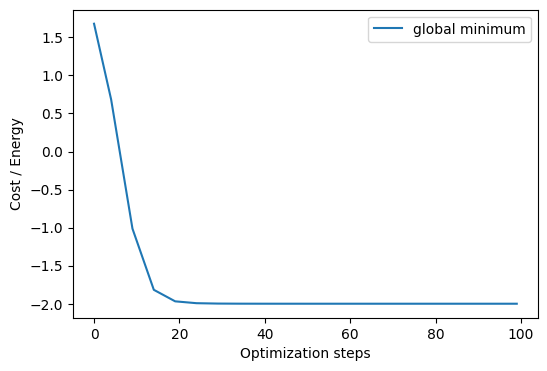

In [9]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))

# Enable processing the Torch trainable tensors
with torch.no_grad():
    plt.plot(x, cost_pt, label = 'global minimum')
    plt.xlabel("Optimization steps")
    plt.ylabel("Cost / Energy")
    plt.legend()
    plt.show()

## Local minimum

If the spins are initialized close to the local minimum of zero energy, the optimizer is likely to get stuck here and never find the global minimum at -2.


In [10]:
torch.manual_seed(9)
p3 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
p4 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)

var_init_loc = [p3, p4]
cost_init_loc = cost(p3, p4)

print("Corresponding cost before optimization:")
print(cost_init_loc)

Corresponding cost before optimization:
tensor(0.0082, dtype=torch.float64, grad_fn=<SubBackward0>)


In [11]:
opt = torch.optim.SGD(var_init_loc, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost(p3, p4)
    loss.backward()
    return loss

var_pt_loc = [var_init_loc]
cost_pt_loc = [cost_init_loc]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        p3n, p4n = opt.param_groups[0]['params']
        costn = cost(p3n, p4n)
        var_pt_loc.append([p3n, p4n])
        cost_pt_loc.append(costn)

        # for clarity, the angles are printed as numpy arrays
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(
            j+1, costn, [p3n.detach().numpy(), p4n.detach().numpy()]),"\n"
        )

Energy after step     5:  0.0032761 | Angles: [array([0.77369911, 2.63471297, 1.07981163]), array([0.26038622, 0.08659858, 1.91060734])] 

Energy after step    10:  0.0013137 | Angles: [array([0.77369911, 2.63406019, 1.07981163]), array([0.26038622, 0.05483683, 1.91060734])] 

Energy after step    15:  0.0005266 | Angles: [array([0.77369911, 2.63379816, 1.07981163]), array([0.26038622, 0.03471974, 1.91060734])] 

Energy after step    20:  0.0002111 | Angles: [array([0.77369911, 2.63369307, 1.07981163]), array([0.26038622, 0.02198151, 1.91060734])] 

Energy after step    25:  0.0000846 | Angles: [array([0.77369911, 2.63365094, 1.07981163]), array([0.26038622, 0.01391648, 1.91060734])] 

Energy after step    30:  0.0000339 | Angles: [array([0.77369911, 2.63363405, 1.07981163]), array([0.26038622, 0.00881044, 1.91060734])] 

Energy after step    35:  0.0000136 | Angles: [array([0.77369911, 2.63362729, 1.07981163]), array([0.26038622, 0.00557782, 1.91060734])] 

Energy after step    40:  0

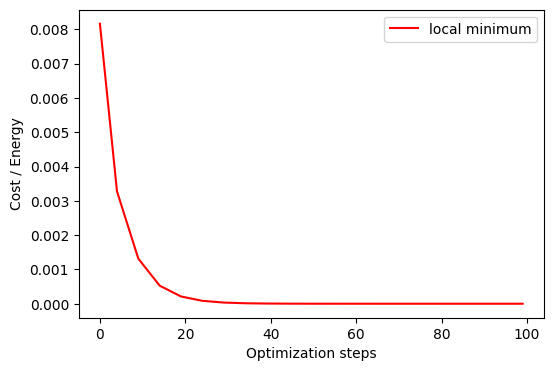

In [12]:
fig = plt.figure(figsize=(6, 4))

# Enable processing the Torch trainable tensors
with torch.no_grad():
    plt.plot(x, cost_pt_loc, 'r', label = 'local minimum')
    plt.xlabel("Optimization steps")
    plt.ylabel("Cost / Energy")
    plt.legend()
    plt.show()

## Send it after class |

Try with different initialization parameters and see how the results change.



# Two Types of Quantum Computers

It is not well-known what problems quantum computers can solve. We can classify quantum computers into “gate model” and “quantum annealing”. They have different use cases and architecture.

## Gate Model

The quantum gate model computers are designed for universal purposes by applying gates to build complex algorithms. They can be considered the upward compatible machines of classical computers but exponentially fast if appropriate quantum algorithms like Shor and Grover are used. The applications include prime factorisation, which becomes a threat to the existing secure data transmission methods over the internet using RSA (Rivest–Shamir–Adleman) keys, quantum simulations which have the potential for finding new medicines, and machine learning. However, the gate model requires high-quality qubit processors; the number of qubits is limited to two digits (except for IBM’s exploratory 127-qubit Eagle system.)

## Quantum Annealing

On the other hand, quantum annealers shine when they are used to search for the best from a vast number of possible combinations. Such challenges are called combinatorial optimisation problems. Many applications of quantum annealing have been reported recently. There are also researches to develop novel machine learning algorithms using quantum annealers. Amin et al. showed that there were possibilities to use quantum annealing hardware as a sampler for Boltzmann Machine by exploiting its quantum nature.

In physics, the minimum energy principle states that the internal energy decreases and approaches the minimum values. If we can formulate our problems in the form of an energy minimisation equation, the quantum annealer will be able to search for the best possible answer.

Quantum annealer is relatively noise-tolerant compared to the gate model. At the time of this writing, the most considerable number of qubits on a quantum processing unit (QPU) is at least five thousand provided by D-Wave’s Advantage solver. It is expected to increase more in the coming years. Five thousand qubits is a large number compared to what is achieved by the gate model. However, what we obtain from the annealer is as limited as a set of 5k-bit values per sampling. Furthermore, not all qubits are connected. Therefore, a hybrid system of classical computing and the quantum annealer is being developed to complement the capabilities of the two systems.

Annealing is a technique used to make quality iron products by heating the material to a certain degree of temperature and cooling it down slowly. The iron’s mechanical characteristics are altered through the heat treatment, which reduces the hardness and increases the elasticity.

Simulated annealing (SA) is a probabilistic technique whose name and idea are derived from annealing in material science. SA is a meta-heuristic in which algorithms approximate the global minimum or maximum of a given function. It uses a parameter called temperature that is initialised with a high value and decreases as the algorithm proceeds, like the physical annealing. High-temperature value promotes the algorithm to look for the various parts of the problem space, which helps to avoid being stuck in local minima or maxima. When the temperature goes down to zero, the state reaches the optimal point if successful. Going through the SA algorithm is outside the scope of this article, and the details on how it works can be found, for example, on the MathWorks website.

Quantum annealing (QA) is an algorithm to solve combinatorial optimisation problems mainly. Instead of using temperature to explore the problem space, QA uses the laws of quantum mechanics to measure the energy state. Starting from the qubits’ dual state, where all the possible combinations of the values are equally likely to happen, we can gradually reduce such quantum mechanical effects by the process called quantum fluctuation to reach the most optimal point where the lowest energy state is realised.

Kadowaki and Nishimori proved that QA converges to the optimal state with a much larger probability than SA in almost all cases on classical computers. The actual quantum annealing machines were developed by D-Wave and built on the ground of their theoretical framework.

## Formulating Problem for QA

QA machines are specialised hardware to solve combinatorial optimisation problems. These problems can be found in many places in our life. For example, an Amazon delivery person needs to find the most optimal route to deliver all parcels given for the day. The objective is to find a route with the shortest distance to visit all the delivery addresses. We can treat the distance as the energy in the QA context and find the path that reaches the ground state. We can also think of a futuristic example where multiple autonomous cars are navigated to optimise the traffic in a specific city area with heavy traffic jams. The objective is to reduce the traffic by minimising the number of overlaps of cars taking the same route simultaneously while each car aims to optimise the travel time to a destination.

Quantum annealers require an objective function to be defined in the Ising model or Quadratic Unconstrained Binary Optimisation (QUBO). Ising model is a mathematical model in statistical mechanics. QUBO is mathematically equivalent to the Ising model and is much simpler to formulate a problem.

QUBO is a minimisation objective function expressed as follows:

$$ H_{QUBO}(x)=\sum_{i=1}^N \sum_{j=1}^N Q_{ij}x_ix_j $$


where $x_i$ and $x_j\_ {i,j =0,1,…,N}$ takes 0 or 1. $Q_{ij}$ is a coefficient matrix of size $n \times n$, which we need to prepare for a QA machine. In case of a problem to search for a global maximum, we can flip the sign to minus to convert the problem into a minimisation problem.

In reality, a problem must be satisfied with one or more constraints. For example, a knapsack problem has a constraint of how many weights you can pack things in the bag. Such constraints are multiplied by weight parameters and are added to the objective function as penalty terms.

## Implementation Using Quantum Annealer

In this section, we would like to code and solve a simple combinatorial optimisation problem in Python and the real Quantum Annealer by D-Wave.

## Preparation

Before starting, we need to sign up for a cloud computing service. D-wave offers trial access to QA solvers with a sixty-second computational time allowance for one month. Please go to D-Wave Leap to find out more. After successful registration, the API token is available on the dashboard.

## Problem Setting

We would like to challenge a simplified portfolio optimisation problem. Suppose there are twenty candidate stocks from FTSE100 to invest in. Our objective is to maximise an expected return rate at the minimum risk while keeping more or less ten stocks in our portfolio.

We will take the following six steps to solve the problem:

1. Import historical stock price data from the internet
2. Prepare data by cleansing and feature engineering
3. Formulate the cost functions and constraints to obtain a QUBO matrix
4. Sample optimisation results from a D-Wave solver
5. Sample optimisation results from a simulated quantum annealing solver
6. Evaluate the outcomes

Each of the above steps is demonstrated in a Colab notebook found in Python Coding in Colab Notebook section.

## Dependencies

Some notes on the Python requirements:

* yfinance is used to retrieve stock price data from Yahoo! Finance.
* Prophet is a python package used to make time-series forecasting. It is possible to do multivariate time series forecasting and add holiday effects easily.
* D-Wave Ocean SDK needs to be installed. The SDK includes packages that are necessary to communicate with D-Wave resources.
* PyQUBO is a library that can construct QUBO from cost and constraints functions.
* OpenJIJ is an open-source meta-heuristics library for the Ising model and QUBO. It simulates the quantum annealers and can be used to experiment without the D-Wave computers. It accepts QUBOs stored in a Python dictionary type.

## Cost and Constraint Function

Our objective in this example is to minimise the sum of two cost functions and one constraint term, namely:

1. the maximisation of return rates
2. the minimisation of risks by lowering portfolio variance
3. the minimisation of the penalty term

1. The maximisation of the return rates can be formulated as a minimisation cost function:

$$ H_{cost1}=-\sum_{i=1}^N R_ix_i $$ (cost function 1)


where $R_i$ is the return rate of the $i$th stock $x_i$. Because $x_i$ only takes a binary value $0$ or $1$, $x_i$ is equivalent with the quadratic term $x_i \times x_i$. Therefore, $H_{cost1}$ function can be equivalent to the following QUBO:

$$ H_{cost1_{QUBO}} = -\sum_{i=j\, i,j=1}^NR_{ij}x_ix_j $$ (cost function as QUBO)


2. The minimisation of portfolio variance is represented as :

$$ H_{cost2}=\sum_{i=1}^N\sum_{j=1}^NW_{ij}x_ix_j $$ (cost function 2)

where W denotes a covariance matrix.

3. The minimisation of the penalty can be formed in mean squared error (MSE) as a constraint term:

$$ H_{const}=(\sum_{i=1}^N x_i- K)^2 $$ (constraint term)


where K is the number of stocks to be selected for the portfolio.

$H_{const}$ can also be transformed to the equivalent QUBOs by expanding the formula:

$$ H_{const}=(\sum_{i=1}^N x_i- K)^2\\ =(\sum_{i=1}^N x_i- K)(\sum_{j=1}^N x_j- K)\\=\sum_{i,j=1}^N x_ix_j-2K\sum_{i=1}^Nx_i + K^2 $$
(Constraint term expanded for QUBO formulation)

$-2K\sum_{i=1}^Nx_i$ part can also be equivalent to the quadratic form, as seen in the above $H_{cost1}$ function. $K^2$ is a constant value called offset which is not included in the QUBO matrix.

We will use the `PyQUBO` library in Python code to generate the QUBO matrix from functions for simplicity.

Thus, we can solve the problem by finding such x that minimises the function H(x) = (H_cost1 + H_cost2 + lambda*H_const), where lambda is a weight parameter for the constraint

# 1. Import historical stock price data from the internet


First of all, Install Yahoo finance library to retrieve stock data.
We will import randomly selected 20 stocks from FTSE100 and extract the historical closing prices for the past 2 years from July 2020.

In [13]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 674.3 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 29.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [14]:
import yfinance as yf  
import numpy as np
import pandas as pd

In [15]:
# list of FTSE100 stocks available at 
# https://www.londonstockexchange.com/indices/ftse-100/constituents/table
# below are randomly selected stocks

stocks_dict = {
    'FLTR.L':'FLUTTER ENTERTAINMENT PLC',
    'SVT.L':'SEVERN TRENT PLC', 
    'LSEG.L':'LONDON STOCK EXCHANGE GROUP PLC', 
    'BNZL.L':'BUNZL PLC', 
    'CPG.L':'COMPASS GROUP PLC', 
    'NXT.L':'NEXT PLC', 
    'ULVR.L':'UNILEVER PLC', 
    'SHEL.L':'SHELL PLC', 
    'CCH.L':'COCA-COLA HBC A', 
    'BRBY.L':'BURBERRY GROUP PLC', 
    'SSE.L':'SSE PLC', 
    'REL.L':'RELX PLC', 
    'EXPN.L':'EXPERIAN PLC', 
    'DCC.L':'DCC PLC ORD', 
    'AZN.L':'ASTRAZENECA PLC', 
    'GSK.L':'GSK PLC ORD', 
    'ADM.L':'ADMIRAL GROUP PLC', 
    'SDR.L':'SCHRODERS PLC', 
    'BATS.L':'BRITISH AMERICAN TOBACCO PLC', 
    'IHG.L':'INTERCONTINENTAL HOTELS GROUP PLC', 
    }
    
stocks = list(stocks_dict.keys()) # list of candidate stocks

data = yf.download(stocks,'2020-07-01','2022-04-30')['Close'] # main data
data_test = yf.download(stocks,'2022-05-01','2022-07-24')['Close'] # testing data

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed


In [16]:
data.describe()

,ADM.L,AZN.L,BATS.L,BNZL.L,BRBY.L,CCH.L,CPG.L,DCC.L,EXPN.L,FLTR.L,GSK.L,IHG.L,LSEG.L,NXT.L,REL.L,SDR.L,SHEL.L,SSE.L,SVT.L,ULVR.L
count,464.000000,464.000000,463.000000,464.000000,464.000000,464.000000,463.000000,463.000000,463.000000,464.000000,464.000000,463.000000,464.000000,464.000000,464.000000,464.000000,463.000000,464.000000,464.000000,464.000000
mean,2949.351293,8366.258621,2787.561555,2537.961207,1804.203375,2294.758621,1466.997840,6042.596112,2933.794816,12754.031149,1475.618385,4722.868251,7975.392241,7204.778017,1997.713362,568.022027,1489.860042,1503.168103,2601.586207,4142.657884
std,298.590229,753.326915,223.859266,228.969271,228.739954,314.297710,176.851449,420.743959,288.931273,2003.651264,128.447452,399.235132,794.814741,952.486937,248.250476,52.854523,299.833511,144.853407,241.375319,357.982299
min,2240.000000,6794.000000,2448.000000,2131.000000,1252.500000,1460.500000,1050.500000,5006.000000,2273.000000,7922.000000,1199.561523,3516.000000,6370.000000,4673.000000,1527.500000,442.510010,900.000000,1171.000000,2168.000000,3328.000000
25%,2756.750000,7931.500000,2643.750000,2363.000000,1630.000000,2073.000000,1393.250000,5785.000000,2738.000000,11400.000000,1385.821991,4549.000000,7371.500000,6282.000000,1788.625000,519.009995,1333.299988,1384.875000,2413.250000,3911.125000
50%,2962.000000,8413.000000,2734.000000,2479.500000,1820.250000,2372.500000,1497.500000,6030.000000,2893.000000,12890.000000,1446.565674,4812.000000,7939.000000,7660.000000,1918.250000,587.179993,1440.400024,1524.250000,2511.000000,4124.500000
75%,3116.250000,8678.250000,2825.750000,2712.750000,1965.250000,2532.250000,1586.250000,6268.000000,3109.000000,14282.500000,1579.234680,5026.000000,8596.000000,7980.500000,2227.250000,606.942520,1660.300049,1612.000000,2823.000000,4358.500000
max,3688.000000,10930.000000,3439.000000,3163.000000,2264.000000,2784.000000,1820.500000,7204.000000,3667.000000,16915.000000,1823.720459,5338.000000,9910.000000,8426.000000,2449.000000,658.070007,2228.000000,1868.500000,3211.000000,4892.000000


In [17]:
data_test.describe()

,ADM.L,AZN.L,BATS.L,BNZL.L,BRBY.L,CCH.L,CPG.L,DCC.L,EXPN.L,FLTR.L,GSK.L,IHG.L,LSEG.L,NXT.L,REL.L,SDR.L,SHEL.L,SSE.L,SVT.L,ULVR.L
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,2185.973684,10508.228070,3466.447368,2814.035088,1629.964912,1777.026316,1710.345614,5494.614035,2555.052632,8403.048070,1758.225729,4650.421053,7403.684211,6209.087719,2244.596491,471.872281,2205.994736,1753.149123,2853.773158,3699.675439
std,173.503948,403.405858,81.319788,146.057225,60.288581,101.134432,237.407090,409.703802,152.041397,1243.157730,34.193845,256.656103,264.537545,239.741846,75.721260,16.497939,148.555222,89.980502,401.790333,129.866329
min,1729.000000,9750.000000,3300.000000,2575.000000,1482.000000,1548.000000,16.700001,4889.000000,2285.000000,81.739998,1684.302124,4193.000000,6738.000000,5764.000000,2081.000000,438.260010,1936.400024,1587.500000,28.070000,3451.500000
25%,2157.000000,10244.000000,3426.000000,2671.000000,1586.000000,1712.000000,1691.500000,5162.000000,2424.000000,8200.000000,1732.252319,4404.000000,7220.000000,5986.000000,2210.000000,458.320007,2044.000000,1677.500000,2794.000000,3609.500000
50%,2228.000000,10506.000000,3478.000000,2837.000000,1636.500000,1775.500000,1730.000000,5308.000000,2578.000000,8468.000000,1758.242188,4695.000000,7390.000000,6148.000000,2265.000000,469.200012,2225.000000,1761.000000,2872.000000,3690.500000
75%,2267.000000,10800.000000,3528.500000,2919.000000,1678.500000,1837.500000,1796.500000,5710.000000,2661.000000,8944.000000,1783.400024,4841.000000,7632.000000,6428.000000,2299.000000,486.200012,2338.000000,1821.000000,2996.000000,3802.500000
max,2561.000000,11232.000000,3628.000000,3108.000000,1743.000000,1945.500000,1854.000000,6268.000000,2835.000000,9760.000000,1815.863037,5150.000000,7894.000000,6686.000000,2375.000000,505.239990,2440.000000,1920.000000,3148.000000,3943.000000


# 2. Prepare data by cleansing and feature engineering


Check null values. We will drop a row with null in this example for simplicity  but please cosnider replacing the values if possible.

In [18]:
print(data.isna().sum()) # null row for each stock

ADM.L     0
AZN.L     0
BATS.L    1
BNZL.L    0
BRBY.L    0
CCH.L     0
CPG.L     1
DCC.L     1
EXPN.L    1
FLTR.L    0
GSK.L     0
IHG.L     1
LSEG.L    0
NXT.L     0
REL.L     0
SDR.L     0
SHEL.L    1
SSE.L     0
SVT.L     0
ULVR.L    0
dtype: int64


In [19]:
data_test.isna().sum() # check for test data

ADM.L     0
AZN.L     0
BATS.L    0
BNZL.L    0
BRBY.L    0
CCH.L     0
CPG.L     0
DCC.L     0
EXPN.L    0
FLTR.L    0
GSK.L     0
IHG.L     0
LSEG.L    0
NXT.L     0
REL.L     0
SDR.L     0
SHEL.L    0
SSE.L     0
SVT.L     0
ULVR.L    0
dtype: int64

In [20]:
data.dropna(inplace=True) # drop the rows
data.shape

(459, 20)

In [21]:
data_test.shape

(57, 20)

## Feature Engineering

To make prediction, we use Prophet. See more at https://facebook.github.io/prophet/

We make time series prediction based on the historical data between July 2020 and April 2022. The period to predict is May 2022 till late July 2022, which is the same period of the data in test set.

The predicted values are transformed to be the average return rate for each stock. We can use it for one of the objectives to maximise the sum of return rates.

In [22]:
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 18.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.5/187.5 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.6 MB/s eta 0:00:0000:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=d1adb90fefb904067f35650132f35c1462d0335672a32dac671aa903f3d5a864
  Stored in directory: /home/obm/.cache/pip/wheels/c2/3a/3d/11734e652782d3f823a08aae1c452e887eb16349750cca3f8a
Successfully built pymeeus

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: 

In [23]:
from prophet import Prophet

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [24]:
pred_return_rate = []
pred_return_rate_mean = []
i = 0 # current index of stock
N = 20 # number of candidate stocks
periods = data_test.shape[0] # number of days to forecast, same as data_test length

for i in range(N): # for each stock
  model = Prophet()
  data['ds'] = data.index # index values (dates) as ds 
  data['y'] = data.iloc[:,i] # stock close price as y
  stock_data = data[['ds','y']] # training data
  model.fit(stock_data)
  future = model.make_future_dataframe(periods=periods) # predict 
  forecast = model.predict(future)['yhat'] # predicted values stored in yhat column
  return_rate = np.zeros(len(forecast)) # return rate to be stored in numpy array
  for j in range(len(forecast)-1): 
    return_rate[j+1] = (forecast[j+1] - forecast[j])/forecast[j] # calculate the return rate per day
  pred_return_rate.append(return_rate)
  pred_return_rate_mean.append(np.mean(return_rate)) # predicted mean return rate for the stock
  data.drop(columns=['ds','y'], inplace=True)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygu7z4jl/04vgcbiz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpygu7z4jl/gc74709l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/obm/Prog/miniconda3/envs/qml/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76984', 'data', 'file=/tmp/tmpygu7z4jl/04vgcbiz.json', 'init=/tmp/tmpygu7z4jl/gc74709l.json', 'output', 'file=/tmp/tmpygu7z4jl/prophet_model6kmbl5_0/prophet_model-20221222121305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disa

In [25]:
print(pred_return_rate_mean)

[-3.295120211693522e-05, 0.0004212352164733634, 0.0006443323333763341, 0.0006180876152479546, 0.0005054489754747284, -0.0011332381597290778, 0.0009594389542370872, -0.0004696525374264205, -0.0002568726047600979, -0.0010414517228963223, 0.00016392271944240828, 0.0006151834219843348, -9.028002715718702e-05, -6.64373367560175e-05, 0.0005966905208675229, -0.00019014641894963337, 0.0011606326569417041, 0.0005490521838582731, 0.0004985535894805963, -0.0005879920495425485]


In [26]:
print(np.mean(pred_return_rate_mean))

0.00014317780640250334


We also calculate actual return rates from the historical stock price data. We will use the results for the calculation of covariance that will be used for the second objective function to reduce the risk by diversify the portfolio items to avoid losing it altogether.

In [27]:
actual_return_rate = []
actual_return_rate_mean = []
N = 20 # number of candidate stocks
for i in range(N): # for each stock
  stock_data = data.iloc[:,i]
  return_rate = np.zeros(len(stock_data)) # return rate to be stored in numpy array
  for j in range(len(stock_data)-1): 
    return_rate[j+1] = (stock_data[j+1] - stock_data[j])/stock_data[j] # calculate the return rate per day
  actual_return_rate.append(return_rate)
  actual_return_rate_mean.append(np.mean(return_rate)) # predicted mean return rate for the stock

In [28]:
actual_return_rate_mean_mean = np.mean(actual_return_rate_mean)
actual_return_rate_mean_mean

0.00039797518633514584

Finally, we calculate the actual return rates on the test set for the final evaluation.

In [29]:
actual_return_rate_test = []
actual_return_rate_mean_test = []
N = 20 # number of candidate stocks
for i in range(N): # for each stock
  stock_data = data_test.iloc[:,i]
  return_rate = np.zeros(len(stock_data)) # return rate to be stored in numpy array
  for j in range(len(stock_data)-1): 
    return_rate[j+1] = (stock_data[j+1] - stock_data[j])/stock_data[j] # calculate the return rate per day
  actual_return_rate_test.append(return_rate)
  actual_return_rate_mean_test.append(np.mean(return_rate)) # predicted mean return rate for the stock

In [30]:
actual_return_rate_mean_mean_test = np.mean(actual_return_rate_mean_test)
actual_return_rate_mean_mean_test

0.26481830738480705

#3. Formulate the cost functions and constraints to obtain a QUBO matrix


## Constraint Terms

In our portfolio optimisation example, let's assume 1 constraint: the number of stock to be included in the portfolio.

In this example, we will use PyQubo, a python library that that can conver the cost function to a quadratic unconstraintbinary optimisation matrix that can be sent to D-wave qunatum annealer and JIJ simulated quantum annealer.



In [31]:
!pip install pyqubo # https://pyqubo.readthedocs.io/en/latest/index.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 33.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 27.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [32]:
from pyqubo import Array, Constraint, Placeholder

In [33]:
x = Array.create('x',shape=N, vartype='BINARY') # array takes binary 0 or 1 indicate to exclude or include a stock in the portfolio, which we need to optimise

In [34]:
# number of stocks constraint
num_stocks = 10 # specify the desired number of stocks
h_const1 = (num_stocks - np.dot(x,x))**2 # MSE from the budget. This lead to x values that makes the portfolio as close as the budget

## Cost Functions

We have set two cost functions to optimise our portfolio. One is to maximise the sum of predicted growth rates that we predicted in the feature engineering section. Another is to minimise the covariance between each of the stock items to be selected in the portfolio. We then add up two cost functions for QUBO.

In [35]:
# cost function 1 to aim the highest return
h_cost1 = 0
h_cost1 -= np.dot(x,pred_return_rate_mean) # maximisation problem. negative to make it minimisation problem

In [36]:
# cost function 2 to balance the portfolio not to put all eggs in one basket
# minimising the sum of covariance leads to the safer choice
h_cost2 = 0
for i in range(N):
  for j in range(N):
    h_cost2 += x[i]*x[j]*np.sum((actual_return_rate[i]-actual_return_rate_mean[i])*(actual_return_rate[j]-actual_return_rate_mean[j]))/len(actual_return_rate[i])

In [37]:
h_cost = h_cost1 + h_cost2

## Prepare QUBO

The problme formulation and representation in QUBO format are habled by PyQubo applications. In the lines below, we compile the model using the objective function that needs to be minimised, then define the constraint coefficient. to_qubo function generates a QUBO matrix in the dictionary type and an offset value which is an costanct value not required for the search for the minimum.

In [38]:
h = h_cost + Placeholder('l1')*Constraint(h_const1,label='num_stocks')
model = h.compile()

In [39]:
feed_dict = {'l1': 2}
qubo, offset = model.to_qubo(feed_dict=feed_dict)

In [40]:
offset

200.0

# 4. Sample optimisation results from a D-Wave solver


Install D-Wave's Ocean SDK to request the computation to the quantum annealer. EmbeddingComposite is used to embed the QUBO to the physical quantum anneler in D-Wave.


In [41]:
!pip install dwave-ocean-sdk # https://docs.ocean.dwavesys.com/en/stable/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.5/236.5 kB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 41.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: pyqubo
    Found existing installation: py

In [42]:
from dwave.system import DWaveSampler, EmbeddingComposite
endpoint = 'https://cloud.dwavesys.com/sapi'
token = '***' # Please relace with your own token

Available annelers depend on the geographic location and machine's online status. The list of solvers can be found on the D-Wave Leap dashboard. 

In [ ]:
sampler_dw = DWaveSampler(solver='Advantage_system4.1',token=token)
sampler_qa = EmbeddingComposite(sampler_dw)

In [ ]:
sampleset_qa = sampler_qa.sample_qubo(qubo,num_reads=10)
records_qa = sampleset_qa.record
print(records_qa)

Above is the result of 10 samples from the solver. 

First list items are the optimised combination of the stock items, 1 indicates the stock is included in the portfolio. 

The second value is the energy state where the lowest number is the best solution. The number shows close to minus two hundred, because the offset value is not included. 

Third number is the number of occurance of the solution. We have 10 reads and each read has unique stock selections.

The last number indicate "chain break" that the connection between qubits are broken then fixed by the software. Ideal soliution should have 0. chain break ratio.

Using records returned from the D-Wave solver, we can validate if the constraint terms are complied.

In [ ]:
portfolio_candidates_qa = []
num_stock_counts_qa = []
record_len = len(records_qa)
for i in range(record_len):
  portfolio = []
  num_stock_count = 0
  for j in range(len(records_qa[i][0])):
    if records_qa[i][0][j] == 1:
      portfolio.append(stocks[j])
      num_stock_count += 1
  portfolio_candidates_qa.append(portfolio)
  num_stock_counts_qa.append(num_stock_count)

In [ ]:
num_stock_counts_qa # number of stocks selected for the portfolio

In our example, 4 of the 10 solutions fit the requirement. We may adjust the coeffient value by increasing the penalty.

Finally, we can select one best solution and display the sotck codes.
We will use 7th record where there was no chain break.

In [ ]:
best_portfolio_qa = portfolio_candidates_qa[7]
print(best_portfolio_qa)

D-Wave has hybrid solver that uses classical computer and quantum annealer. 
The solver 'hybrid_binary_quadratic_model_version2' can have up to 1,000,000 variables.

To try the hybrid solver, we need to import LeapHybridSampler library. The difference from the quantum solver are: 

- it does not require embed composite
- only one sample record is returned (no num_reads parameter)
- it consumes more QPU time (different conversion rate applies QPU: Hybrid 1:20)


In [ ]:
from dwave.system import LeapHybridSampler
sampler_dw_hybrid = LeapHybridSampler(solver='hybrid_binary_quadratic_model_version2',token=token)
sampleset_qa_hybrid = sampler_dw_hybrid.sample_qubo(qubo)
records_qa_hybrid = sampleset_qa_hybrid.record
print(records_qa_hybrid)

# 5. Sample optimisation results from a simulated quantum annealing solver


There is publicly available open source QA simulators provided by [OpenJIJ](https://www.openjij.org/). It can be used as an alternative the real quantum annerler. We can use the same QUBO prepared by PyQubo.



In [ ]:
!pip install openjij

In [ ]:
from openjij import SQASampler
sampler_jij = SQASampler()
sampleset_sqa = sampler_jij.sample_qubo(qubo,num_reads=10)
records_sqa = sampleset_sqa.record

In [ ]:
print(records_sqa)

In [ ]:
portfolio_candidates_sqa = []
num_stock_counts_sqa = []
record_len = len(records_sqa)
for i in range(record_len):
  portfolio = []
  num_stock_count = 0
  for j in range(len(records_sqa[i][0])):
    if records_sqa[i][0][j] == 1:
      portfolio.append(stocks[j])
      num_stock_count += 1
  portfolio_candidates_sqa.append(portfolio)
  num_stock_counts_sqa.append(num_stock_count)

In [ ]:
num_stock_counts_sqa

In [ ]:
best_portfolio_sqa = portfolio_candidates_sqa[-1]
print(best_portfolio_sqa)

#6. Evaluate the outcomes


We can select the best portfolio selection from QA and SQA samples.

In [ ]:
portfolio_qa = records_qa[7][0] # best combination from QA hybdrid solver
print(portfolio_qa)

In [ ]:
portfolio_sqa = records_sqa[-1][0] # best combination from SQA hybdrid solver
print(portfolio_sqa)

We compare the cost 1: increases the return rate.
The more return is achieved if the number is smaller than the other.

In [ ]:
h_cost1_qa = 0
h_cost1_qa -= np.dot(portfolio_qa,actual_return_rate_mean_test) # maximisation problem. negative to make it minimisation problem
print(h_cost1_qa) # return rate factor by QA

In [ ]:
h_cost1_sqa = 0
h_cost1_sqa -= np.dot(portfolio_sqa,actual_return_rate_mean_test) # maximisation problem. negative to make it minimisation problem
print(h_cost1_sqa) # return rate cost by SQA

We also compare the cost 2: decrease the risk.
The more return is achieved if the number is smaller than the other.

In [ ]:
N= 20
h_cost2_qa = 0
for i in range(N):
  for j in range(N):
    h_cost2_qa += portfolio_qa[i]*portfolio_qa[j]*np.sum((actual_return_rate_test[i]-actual_return_rate_mean_test[i])*(actual_return_rate_test[j]-actual_return_rate_mean_test[j]))/len(actual_return_rate_test[i])
print(h_cost2_qa)

In [ ]:
N= 20
h_cost2_sqa = 0
for i in range(N):
  for j in range(N):
    h_cost2_sqa += portfolio_sqa[i]*portfolio_sqa[j]*np.sum((actual_return_rate_test[i]-actual_return_rate_mean_test[i])*(actual_return_rate_test[j]-actual_return_rate_mean_test[j]))/len(actual_return_rate_test[i])
print(h_cost2_sqa)

We can check the costs in case we selected all 20 stocks as benchmark.
The numbers will be divided by two for comparison.

In [ ]:
portfolio_all = np.ones(20)
h_cost1_all = 0
h_cost1_all -= np.dot(portfolio_all,actual_return_rate_mean_test) # maximisation problem. negative to make it minimisation problem
print(h_cost1_all/2)

In [ ]:
N= 20
h_cost2_all = 0
for i in range(N):
  for j in range(N):
    h_cost2_all += portfolio_all[i]*portfolio_all[j]*np.sum((actual_return_rate_test[i]-actual_return_rate_mean_test[i])*(actual_return_rate_test[j]-actual_return_rate_mean_test[j]))/len(actual_return_rate_test[i])
print(h_cost2_all/2)

Finally, the costs from Hybrid solver as follows:

In [ ]:
portfolio_qa_hybrid = records_qa_hybrid[0][0] # best combination from QA hybdrid solver
print(portfolio_qa_hybrid)

In [ ]:
h_cost1_qa_hybrid = 0
h_cost1_qa_hybrid -= np.dot(portfolio_qa_hybrid,actual_return_rate_mean_test) # maximisation problem. negative to make it minimisation problem
print(h_cost1_qa_hybrid) # return rate factor by QA Hybrid Solver

In [ ]:
N= 20
h_cost2_qa_hybrid = 0
for i in range(N):
  for j in range(N):
    h_cost2_qa_hybrid += portfolio_qa_hybrid[i]*portfolio_qa_hybrid[j]*np.sum((actual_return_rate_test[i]-actual_return_rate_mean_test[i])*(actual_return_rate_test[j]-actual_return_rate_mean_test[j]))/len(actual_return_rate_test[i])
print(h_cost2_qa_hybrid)

With compariso to the benchmark, we can observe sample reocrds from QA/SQA/Hybdrid solvers as: 

- QA solver showed high-return but high-risks.
- SQA solver recommended slightly lower return but minimum risk
- Hybrid solver showed very similar costs for both return and risk as SQA

Above is just a comparison of 1 sample record. We could analyse more sample records and visualsing the outcome. We could also tune hyper-parameters, like constraint coefficient.